In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
import math
import datetime
import networkx as nx
import os

In [2]:
def TodaysDate():
        
    Today = datetime.date.today()
    TodaysDate = Today.strftime('%d%b%Y')
    
    return TodaysDate

In [3]:
def DNAcoding_sequence(DNASequence, QualityScoreSequence, start_sequence, stop_sequence):
#utilises ONLY ONE stop_sequence, returns ONLY ONE coding_sequence
    
    QualityScoreString = """!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"""
    ThresholdQualityScore = 29 # ThresholdQualityScore must be between 0 and 93
    ThresholdQualityString = QualityScoreString[ThresholdQualityScore:]
    
    MinLength = 24
    MaxLength = 240
            
    StartIndex = DNASequence.find(start_sequence) + len(start_sequence)
    StopIndex = DNASequence.rfind(stop_sequence)
    coding_sequence =  DNASequence[StartIndex:StopIndex]
    if MinLength <= len(coding_sequence) and len(coding_sequence) <= MaxLength and len(coding_sequence)%3 == 0:
        for Character in QualityScoreSequence[StartIndex:StopIndex]:
            if Character not in ThresholdQualityString:
                return None
        return str(coding_sequence)

In [4]:
def Translation(coding_sequence):
#translates DNA sequence

    TranslationCode = {
                    'AAA':'K','AAC':'N','AAG':'K','AAU':'N',
                    'ACA':'T','ACC':'T','ACG':'T','ACU':'T',
                    'AGA':'R','AGC':'S','AGG':'R','AGU':'S',
                    'AUA':'I','AUC':'I','AUG':'M','AUU':'I',
                    
                    'CAA':'Q','CAC':'H','CAG':'Q','CAU':'H',
                    'CCA':'P','CCC':'P','CCG':'P','CCU':'P',
                    'CGA':'R','CGC':'R','CGG':'R','CGU':'R',
                    'CUA':'L','CUC':'L','CUG':'L','CUU':'L',
                    
                    'GAA':'E','GAC':'D','GAG':'E','GAU':'D',
                    'GCA':'A','GCC':'A','GCG':'A','GCU':'A',
                    'GGA':'G','GGC':'G','GGG':'G','GGU':'G',
                    'GUA':'V','GUC':'V','GUG':'V','GUU':'V',
                    
                    'UAA':'#','UAC':'Y','UAG':'*','UAU':'Y',
                    'UCA':'S','UCC':'S','UCG':'S','UCU':'S',
                    'UGA':'&','UGC':'C','UGG':'W','UGU':'C',
                    'UUA':'L','UUC':'F','UUG':'L','UUU':'F'
                        }
    # UAA (ochre) — #
    # UAG (amber) — *
    # UGA (opal) — &
                    
    TranscriptionCode = {'A':'A','C':'C','G':'G','T':'U','U':'T'}
      
    RNASequence = ''
    for Nucleotide in coding_sequence:
        RNASequence += TranscriptionCode.get(Nucleotide,'X')
    #converts DNA to RNA
    #print RNASequence
        
    peptide = ''
    while len(RNASequence) != 0:
        peptide += TranslationCode.get(RNASequence[0:3],'Do not fuck with me!')
        RNASequence = RNASequence[3:]
    return peptide

In [5]:
def SingleSelectionRoundSummary(fastq_file_path):
#returns a list of lists with peptide-sequences and their frequencies, sorted by frequency in descending order
    
    RawDataFile = open(fastq_file_path, 'r')
    lines = RawDataFile.readlines()
    RawDataFile.close
    
#     start_sequence = 'ATG' # Met codon
    #stop_sequence = 'TGCGGCAGC'# Akane seams to have trimmed siquences
#     stop_sequence = 'TAG' # amber stop codon
    
#     start_sequence = 'TAATACGACTCACTATAGGGTTAACTTTAAGAAGGAGATATACATATG'    # NNK - T7g10M.F48
#     stop_sequence = 'TGCGGCAGCGGCAGCGGCAGCTAGGACGGGGGGCGGAAA' #NNK - CGS3an13.R39
    start_sequence = 'CATATGTATATCTCCTTCTTAAAGTT'  # NNK - T7g10M.F48 truncated reverse complement
    stop_sequence = 'TTTCCGCCCCCCGTCCTAGCTGCCGCTGCCGCTGCCGCA' #NNK - CGS3an13.R39 reverse complement
    #start_sequence = 'TAATACGACTCACTATAGGGTTGAACTTTAAGTAGGAGATATATCCATG'   #NNU - T7-CH-F49
    #stop_sequence = 'TGTGGGTCTGGGTCTGGGTCTTAGGACGGGGGGCGGAAA'  #NNU - CGS3-CH-R39
    
    SingleSelectionRoundSummary = {}
    #creates empty SingleSelectionRoundSummary dictionary to store the results from a single round of selection
    #SingleSelectionRoundSummary = {peptideY:    {coding_sequence_YZ:    Occurrence_YZ}}
        
    #populates SingleSelectionRoundSummary dictionary with the results from a single round of selection
    for i,line in enumerate(lines):
        if start_sequence in line and stop_sequence in line:
            coding_sequence = DNAcoding_sequence(line, lines[i + 2], start_sequence, stop_sequence)
            if coding_sequence != None:
                peptide = Translation(coding_sequence)
                if peptide not in SingleSelectionRoundSummary:
                    SingleSelectionRoundSummary[str(peptide)] = {str(coding_sequence) : 1}
                else:
                    if coding_sequence not in SingleSelectionRoundSummary[str(peptide)]:
                        SingleSelectionRoundSummary[str(peptide)][str(coding_sequence)] = 1
                    else:
                        SingleSelectionRoundSummary[str(peptide)][str(coding_sequence)] += 1

    return SingleSelectionRoundSummary

In [6]:
def HammingDistance(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '%'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '%'
    
    HammingDistance = 0
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            HammingDistance = HammingDistance
        else:
            HammingDistance = HammingDistance + 1
            
    return HammingDistance

In [7]:
def HammingDistanceBasedFormating(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '-'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '-'
    
    HammingDistance = 0
    FormatedSequence2 = ''
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            FormatedSequence2 += Sequence2[i].lower()
            HammingDistance = HammingDistance
        else:
            FormatedSequence2 += Sequence2[i]
            HammingDistance = HammingDistance + 1            
    return FormatedSequence2

In [8]:
def Completedisplay_summary(data_directory_path):
# returns a display_summary dictionary with the following structure
# display_summary = {SelectionRound_X:    {peptideXY:    {CodingDNA_XYZ:    Occurrence_XYZ}}}

    Completedisplay_summary = {}
    # creates empty display_summary dictionary to store the results from all the rounds of selection

    for file in os.listdir(data_directory_path):
        print(file)
        
        file_path = os.path.join(data_directory_path, file)
          
        if file.endswith('.fastq'): # this conditional is necessary; without it some shit appears in the beginning of the file list
            cycle_numberFirstDigit = file[file.find('.')-2]
            cycle_numberSecondDigit = file[file.find('.')-1]
            if cycle_numberFirstDigit == '0':
                cycle_number = int(cycle_numberSecondDigit)
                #print cycle_number
            elif cycle_numberFirstDigit != '0':
                cycle_number = int(file[file.find('.')-2 : file.find('.')])
                #print cycle_number
        #(1.A) extracts the round number from the file name (file name should have two digit number before full stop — '00.') 
            print(file_path)
            SelectionRoundSummary = SingleSelectionRoundSummary(file_path)
            #(1.B) extracts single round results 
                    
            Completedisplay_summary[cycle_number] = SelectionRoundSummary
            #(1.C) populate ConcatenatedResultsList
            #print ConcatenatedResultsList
            
    return Completedisplay_summary

In [9]:
def peptidesOccurrences_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    
    peptidesOccurrences_BY_Round = {}
    for Round in display_summary:
        peptidesOccurrences_IN_Round = {}
        for peptide in display_summary[Round]:
            peptidesOccurrences_IN_Round[peptide] = sum(display_summary[Round][peptide].values())
        peptidesOccurrences_BY_Round[Round] = peptidesOccurrences_IN_Round
        
    return peptidesOccurrences_BY_Round

In [10]:
def DNAsOccurrences_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    
    DNAsOccurrences_BY_Round = {}
    for Round in display_summary:
        DNAsOccurrences_IN_Round = {}
        for peptide in display_summary[Round]:
            for DNA in display_summary[Round][peptide]:
                DNAsOccurrences_IN_Round[DNA] = display_summary[Round][peptide][DNA]
        DNAsOccurrences_BY_Round[Round] = DNAsOccurrences_IN_Round

    return DNAsOccurrences_BY_Round

In [11]:
def TotalReads_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)
    
    TotalReads_BY_Round = {}
    for Round in display_summary:
        TotalReads_BY_Round[Round] = sum(peptides_BY_Round[Round].values())
        
    return TotalReads_BY_Round

In [12]:
def BaseRoundSortedpeptidesList(data_directory_path, base_cycle):
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)  
            
    peptidesOccurrencesInBaseRound = peptides_BY_Round[base_cycle]
    BaseRoundSortedpeptidesList = sorted(peptidesOccurrencesInBaseRound, key = peptidesOccurrencesInBaseRound.get, reverse = True)
    
    return BaseRoundSortedpeptidesList

In [13]:
def BaseRoundSortedDNAsList(data_directory_path, base_cycle):
    DNAs_BY_Round = DNAsOccurrences_BY_Round(data_directory_path)  
            
    DNAsOccurrences_IN_BaseRound = DNAs_BY_Round[base_cycle]
    BaseRoundSortedDNAsList = sorted(DNAsOccurrences_IN_BaseRound, key = DNAsOccurrences_IN_BaseRound.get, reverse = True)
    
    return BaseRoundSortedDNAsList

In [14]:
def DNAClonesOccurrences_BY_Round_BY_peptide(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    
    DNAClonesOccurrences_BY_Round_BY_peptide = {}
    for Round in display_summary:
        DNAClonesOccurrences_BY_peptide = {}
        for peptide in display_summary[Round]:
            DNAClonesOccurrences_BY_peptide[peptide] = len(display_summary[Round][peptide])
        DNAClonesOccurrences_BY_Round_BY_peptide[Round] = DNAClonesOccurrences_BY_peptide
        
    return DNAClonesOccurrences_BY_Round_BY_peptide

In [15]:
def peptidesAppearances_BY_Round(BaseRoundSortedpeptidesList, peptidesOccurrences_BY_Round):
    
    peptidesAppearances_BY_Round = {}
    
    for peptide in BaseRoundSortedpeptidesList:
        peptidesAppearances_BY_Round[peptide] = []
        for Round in peptidesOccurrences_BY_Round:
            if peptide in peptidesOccurrences_BY_Round[Round]:
                peptidesAppearances_BY_Round[peptide] += [Round]
    return peptidesAppearances_BY_Round

In [16]:
def DNAsAppearances_BY_Round(BaseRoundSortedDNAsList, DNAsOccurrences_BY_Round):
    
    DNAsAppearances_BY_Round = {}
    
    for DNA in BaseRoundSortedDNAsList:
        DNAsAppearances_BY_Round[DNA] = []
        for Round in DNAsOccurrences_BY_Round:
            if DNA in DNAsOccurrences_BY_Round[Round]:
                DNAsAppearances_BY_Round[DNA] += [Round]
    return DNAsAppearances_BY_Round

In [17]:
def ATCount(DNASequence):
    ATCount = 0
    for Nucleotide in DNASequence:
        if Nucleotide == 'A' or Nucleotide == 'T':
            ATCount += 1            
    return ATCount

In [18]:
def display_summaryReport(data_directory_path, base_cycle, n_top_peptides, file_name):
    
    today = TodaysDate()

    DNAs_BY_Round = DNAsOccurrences_BY_Round(data_directory_path)
    TotalDNAs_BY_Round = TotalReads_BY_Round(data_directory_path)
    
    BaseRoundSortedDNAs = BaseRoundSortedDNAsList(data_directory_path, base_cycle)
    BaseRoundTopSortedDNAs = BaseRoundSortedDNAs[0 : (n_top_peptides)]
    
    display_summary = Completedisplay_summary(data_directory_path)
    SortedRoundsList = sorted(display_summary.keys())
    
    display_summaryFileNameCSV = str(today) + 'display_summary' + file_name + '.csv'
    display_summaryReportFile = open(display_summaryFileNameCSV, 'w')
    
    display_summaryReportFile.write('DNA sequence' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write('round # ' + str(Round) + ' occurrence (#)' + ',')
    display_summaryReportFile.write('\n')
    
    for DNA in BaseRoundTopSortedDNAs:
        display_summaryReportFile.write(DNA + ',')
        for Round in SortedRoundsList:
            display_summaryReportFile.write(str(DNAs_BY_Round[Round].get(DNA, 0)) + ',')
        display_summaryReportFile.write('\n')
        
    display_summaryReportFile.write('total #' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write(str(TotalDNAs_BY_Round[Round]) + ',')
    display_summaryReportFile.write('\n\n\n')
    
    display_summaryReportFile.write('DNA sequence' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write('round # ' + str(Round) + ' fraction (%)' + ',')
    display_summaryReportFile.write('\n')
    
    for DNA in BaseRoundTopSortedDNAs:
        display_summaryReportFile.write(DNA + ',')
        for Round in SortedRoundsList:
            DNAFraction = float((DNAs_BY_Round[Round].get(DNA, 0)))/float(TotalDNAs_BY_Round[Round])
            display_summaryReportFile.write('{:.3%}'.format(DNAFraction) + ',')
        display_summaryReportFile.write('\n')
            
    display_summaryReportFile.close()
        
#-------------------------------------------------------------------------------
   
    # Create a figure of size 8x6 inches, 500 dots per inch
    plt.figure(figsize = (8, 6),
               dpi = 500)
    # Create 'ggplot' style
    plt.style.use('fivethirtyeight')
    # Create a new subplot from a grid of 1x1
    Graph = plt.subplot(1, 1, 1)
    
    # Map colours onto lines
    cNorm  = matplotlib.colors.Normalize(vmin = 0,
                                         vmax = n_top_peptides - 1)
    scalarMap = matplotlib.cm.ScalarMappable(norm = cNorm,
                                             cmap = 'Paired')
    
    Xs = []
    Ys = []
    for DNA in BaseRoundTopSortedDNAs:
        DNAsFractions_BY_Round = []
        for Round in SortedRoundsList:
            DNAsFractions_BY_Round += [float((DNAs_BY_Round[Round].get(DNA, 0)))/float(TotalDNAs_BY_Round[Round])]
        
        x = SortedRoundsList
        y = DNAsFractions_BY_Round
        Xs += x
        Ys += y
        
        # Set peptideColour
        DNAColour = scalarMap.to_rgba(BaseRoundTopSortedDNAs.index(DNA))
        
        #DNALabel = DNA + '\n' + Translation(DNA)
        print (DNA)
        
        DNALabel = (HammingDistanceBasedFormating('GTTTGGGATCCGAGGACGTTTTATTTGTCTAGGATT', DNA) + '\n' +
                    'A/T count ' + str(ATCount(DNA)))
        
        plt.plot(x, y,
                 'o-',
                 c = DNAColour,
                 lw = 2.0,
                 ms = 4.0,
                 mew = 0.1,
                 mec = '#191919',
                 label = DNALabel)
    
    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
    plt.axis([XMin, XMax, YMin, YMax])
    
    plt.xticks([0, 1, 2],
               ['Library\nInput', 'Pre\nSelection', 'Post\nSelection'],
               fontsize = 10)
    #plt.xlabel('Selection Round #',
    #           fontsize = 10)
    
    plt.yticks([0.2, 0.4, 0.6, 0.8],
               fontsize = 10)       
    plt.ylabel('DNA Fraction',
               fontsize = 10)
    
    legend = plt.legend(#BaseRoundTopSortedDNAs,
                        title = 'DNA sequences coding for VWDPRTFYLSRI',
                        loc = 'upper center',
                        bbox_to_anchor = (0.5, -0.15),
                        fancybox = True,
                        shadow = False,
                        fontsize = 10,
                        ncol = 2)
    
    Graph.get_legend().get_title().set_size('small')
    
    display_summaryFileNamePNG = str(today) + 'display_summary' + file_name + '.png'
    
    plt.savefig(display_summaryFileNamePNG,
                bbox_extra_artists=[legend],
                bbox_inches='tight',
                dpi = 300)
    plt.show()
    plt.close()

a_vs_o_w_00.fastq
../data/a_vs_o/a_vs_o_w_00.fastq
.DS_Store
a_vs_o_w_02.fastq
../data/a_vs_o/a_vs_o_w_02.fastq
a_vs_o_w_01.fastq
../data/a_vs_o/a_vs_o_w_01.fastq
a_vs_o_w_00.fastq
../data/a_vs_o/a_vs_o_w_00.fastq
.DS_Store
a_vs_o_w_02.fastq
../data/a_vs_o/a_vs_o_w_02.fastq
a_vs_o_w_01.fastq
../data/a_vs_o/a_vs_o_w_01.fastq
a_vs_o_w_00.fastq
../data/a_vs_o/a_vs_o_w_00.fastq
.DS_Store
a_vs_o_w_02.fastq
../data/a_vs_o/a_vs_o_w_02.fastq
a_vs_o_w_01.fastq
../data/a_vs_o/a_vs_o_w_01.fastq
a_vs_o_w_00.fastq
../data/a_vs_o/a_vs_o_w_00.fastq
.DS_Store
a_vs_o_w_02.fastq
../data/a_vs_o/a_vs_o_w_02.fastq
a_vs_o_w_01.fastq
../data/a_vs_o/a_vs_o_w_01.fastq
a_vs_o_w_00.fastq
../data/a_vs_o/a_vs_o_w_00.fastq
.DS_Store
a_vs_o_w_02.fastq
../data/a_vs_o/a_vs_o_w_02.fastq
a_vs_o_w_01.fastq
../data/a_vs_o/a_vs_o_w_01.fastq


ValueError: min() arg is an empty sequence

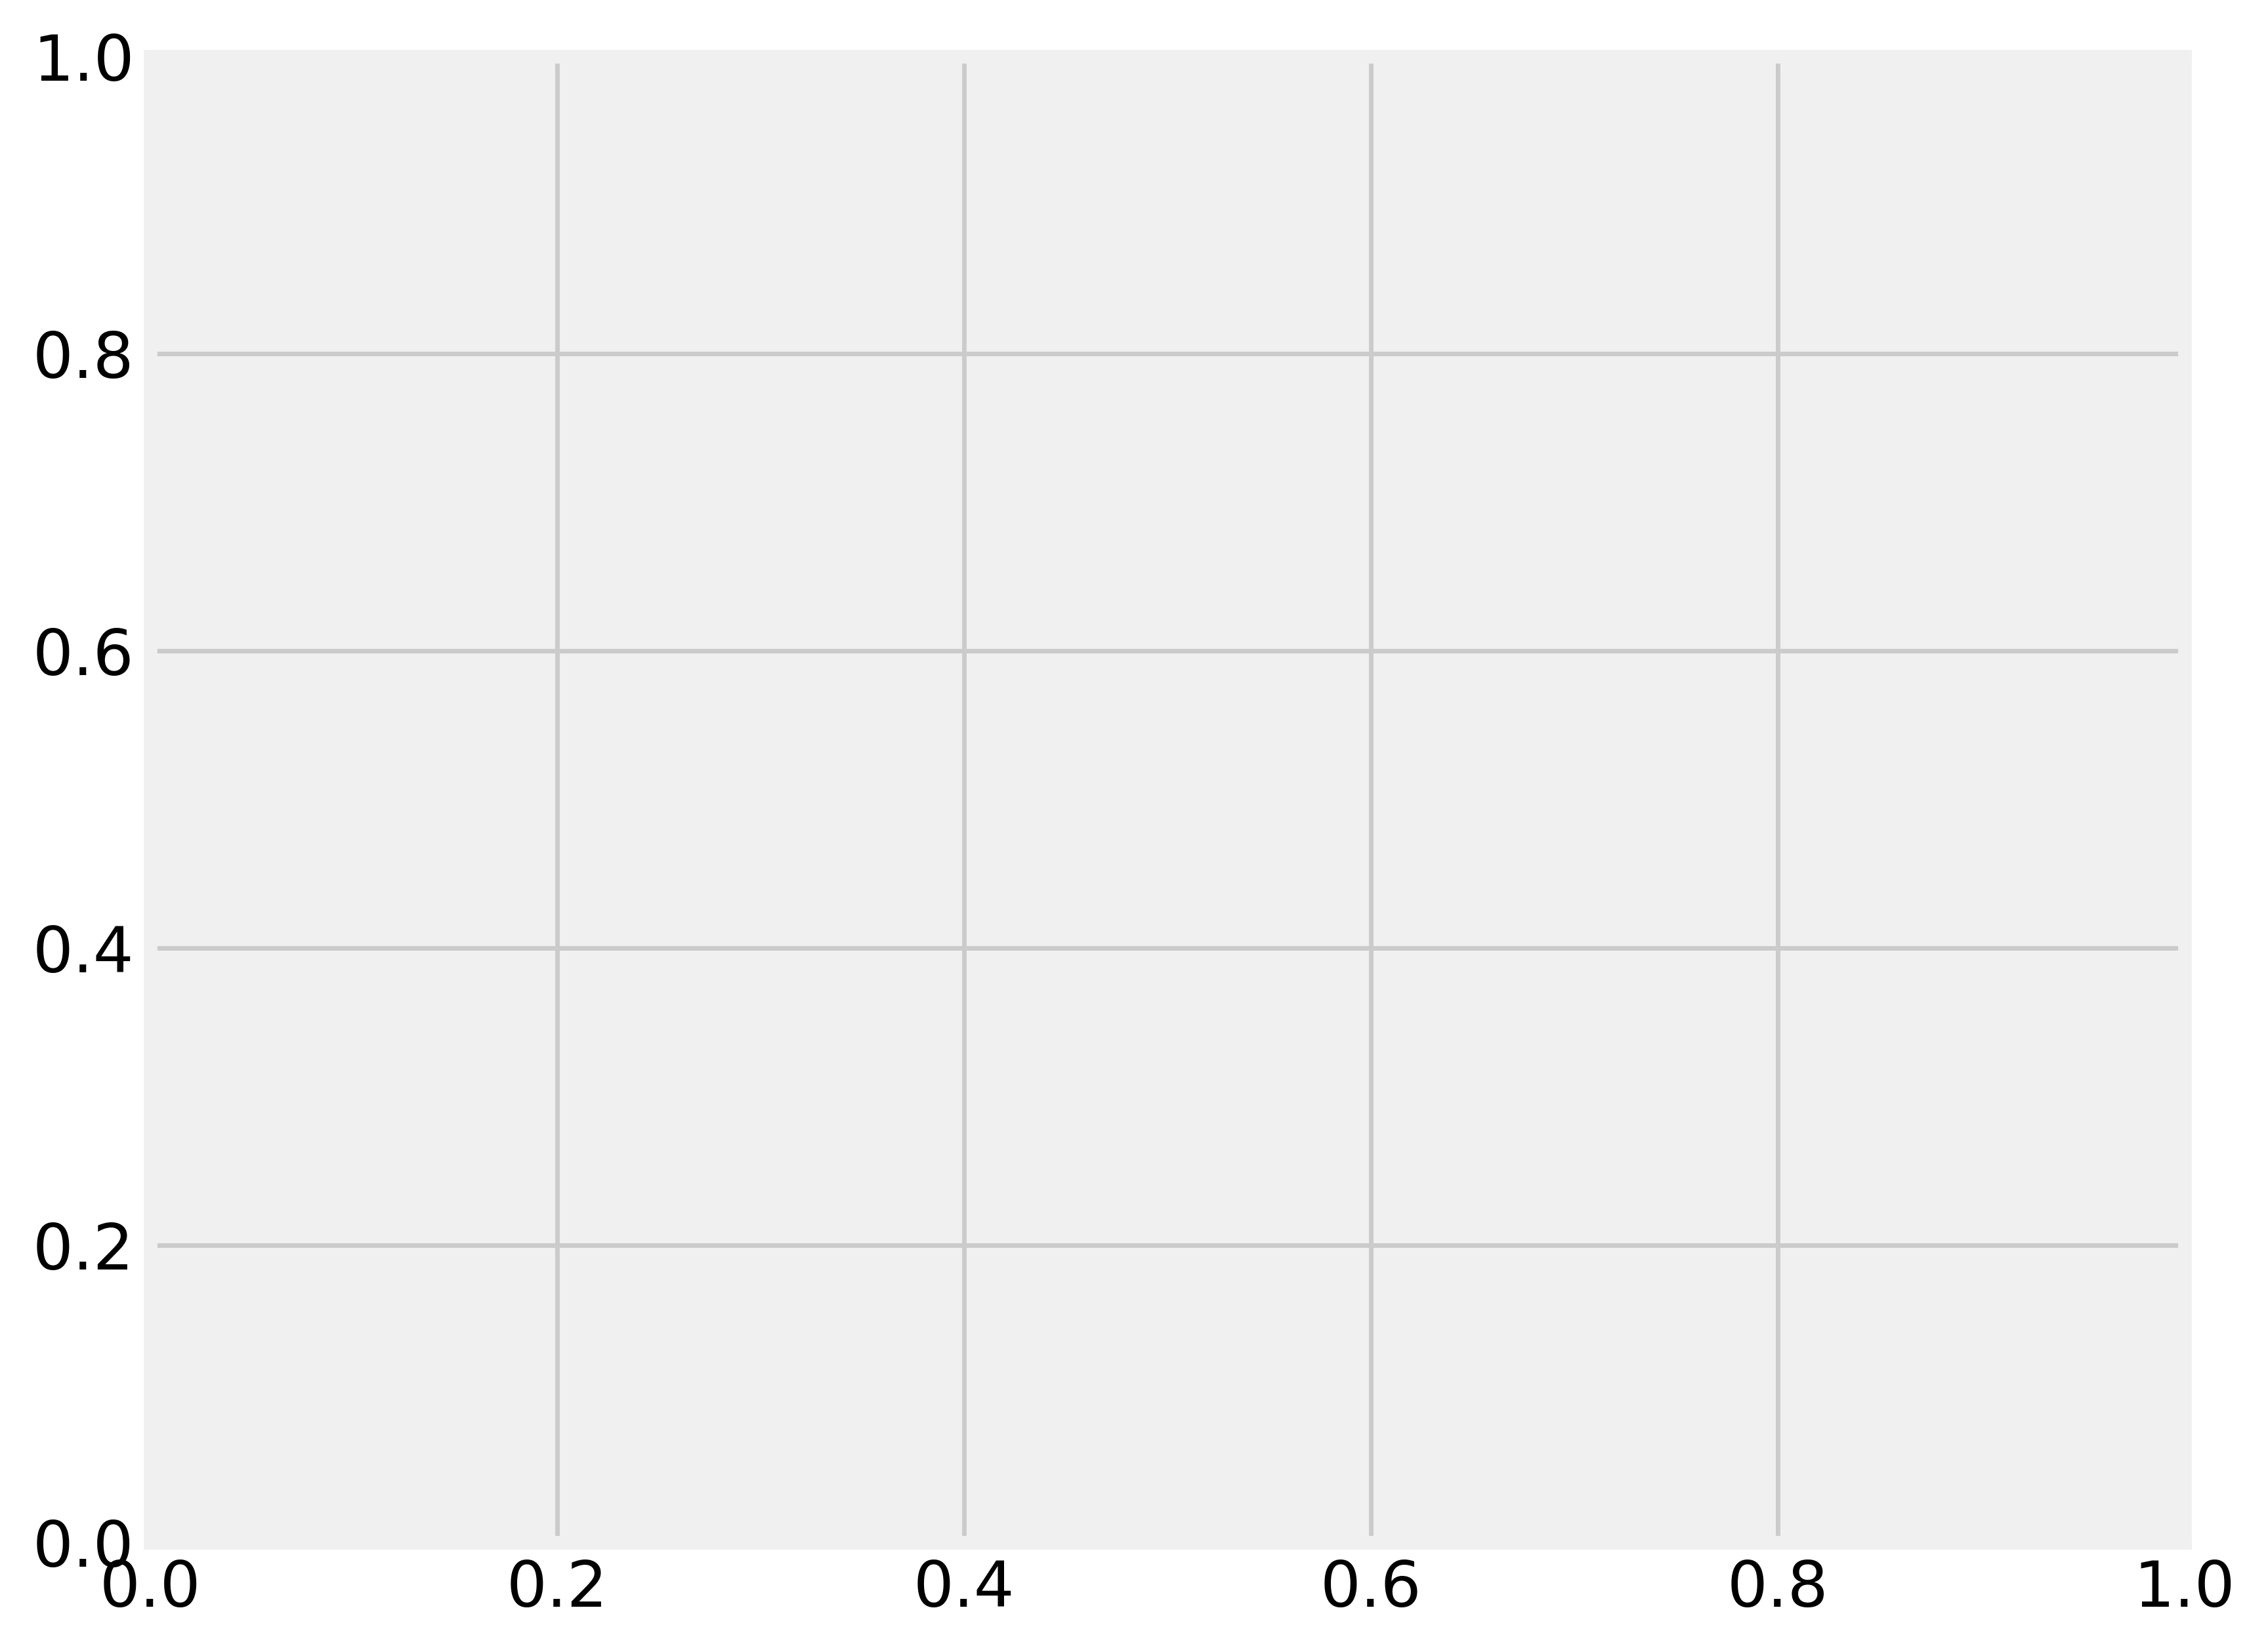

In [19]:
data_directory_path = '../data/a_vs_o/'
base_cycle = 2
TopNpeptidesNumber = 2
SummaryFileName = 'Paper04_AvsO'

display_summaryReport(data_directory_path, base_cycle, TopNpeptidesNumber, SummaryFileName)

GTTTGGGATCCGAGGACGTTTTATTTGTCTAGGATT
GTGTGGGATCCGCGCACCTTTTATCTGAGCCGCATT


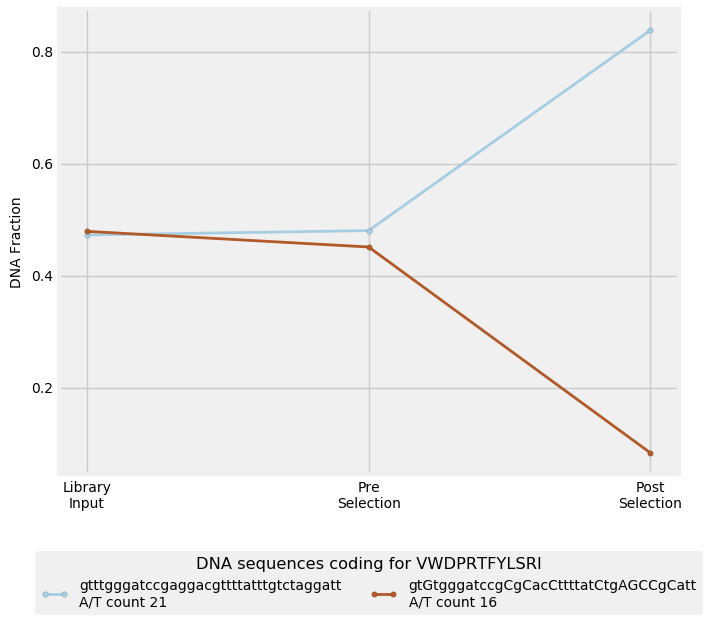

In [19]:
data_directory_path = '/Users/nikita/Documents/DataSequensing/SelectionBias/AvsO/AvsOWith/SequencingResults'
base_cycle = 2
TopNpeptidesNumber = 2
SummaryFileName = 'Paper04_AvsO'

display_summaryReport(data_directory_path, base_cycle, TopNpeptidesNumber, SummaryFileName)